# **Boat Object Detection with YOLO**

In this project, we build a complete object-detection pipeline for identifying boats in satellite imagery.
We fine-tune a YOLOv8 model on a custom dataset, visualize the ground-truth annotations, prepare the dataset in the YOLO format, train the model, and finally generate predictions on unseen test images.
The goal is to obtain accurate bounding-box predictions and evaluate the model’s performance on real-world data.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd

## **Data loading**

In this section, we download and load the training and test data provided for this project.
The dataset consists of:
	•	X_train.pkl – training images stored as NumPy arrays
	•	y_train.pkl – normalized YOLO-format bounding boxes for each training image
	•	X_test.pkl – test images (without labels)

We download the files, load them into memory, and check their shapes to understand the structure of the dataset.

In [2]:
# URLs for the dataset files
data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
data_train_labels_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
data_test_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name}')

# Download the files
download_file(data_train_features_url, 'X_train.pkl')
download_file(data_train_labels_url, 'y_train.pkl')
download_file(data_test_features_url, 'X_test.pkl')

Downloaded X_train.pkl
Downloaded y_train.pkl
Downloaded X_test.pkl


In [3]:
# Load the training data
with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format - class_id, x_center, y_center, width, height):\n{y[0]}")

Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format - class_id, x_center, y_center, width, height):
[[0.       0.659871 0.57177  0.109442 0.162679]]


In [14]:
print(len(X))
print(X[0].shape)
print(type(X[0]))

496
(418, 466, 3)
<class 'numpy.ndarray'>


## **Data Visualization**

We inspect several training images together with their ground-truth bounding boxes.
The labels are provided in normalized YOLO format (class_id, x_center, y_center, width, height) and we convert them into pixel coordinates for visualization.

In [4]:
def plot_image_with_boxes(image, boxes, ax=None):
    """
    Plot an image with bounding boxes
    boxes: numpy array with shape (n, 5) - [class_id, x_center, y_center, width, height]
    All box coordinates are normalized (0-1)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image)
    height, width = image.shape[:2]
    
    # Draw each bounding box
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        
        # Convert from normalized YOLO format to pixel coordinates
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        
        # Calculate top-left corner
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        
        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), box_width_px, box_height_px,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, 'boat', color='red', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.axis('off')
    return ax

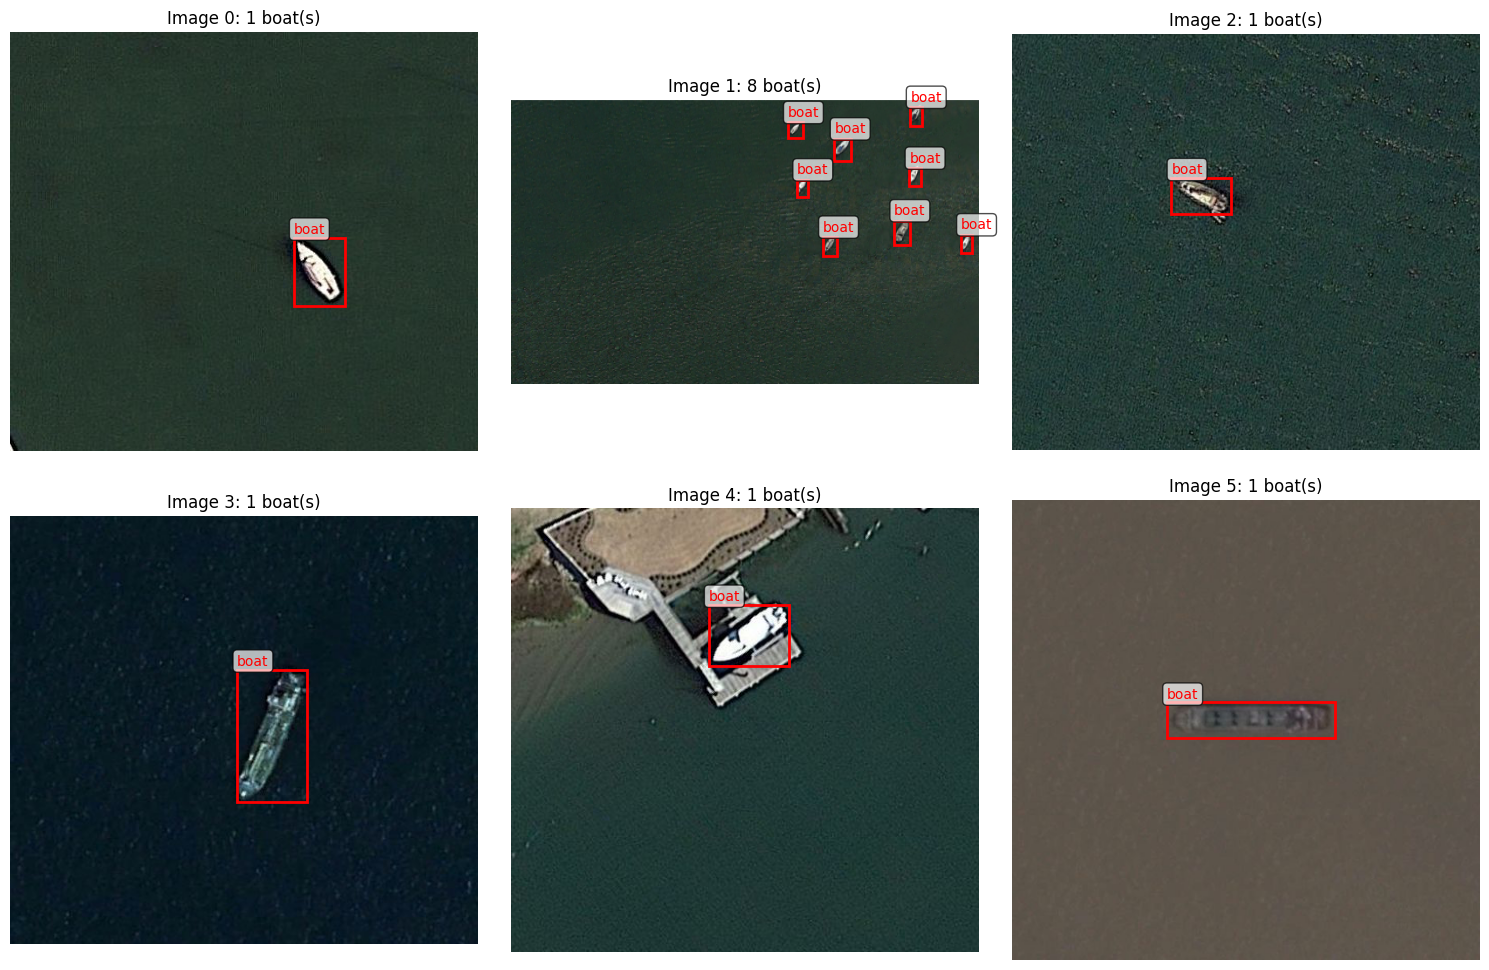

In [5]:
# Display 5 sample images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')

plt.tight_layout()
plt.show()

## **Model Setup**

We start from a pre-trained YOLOv8n model (trained on the COCO dataset) and run it on one training image to obtain a baseline. This quick sanity check confirms that the generic model does not detect boats correctly in satellite imagery, which motivates fine-tuning on our custom dataset.

In [6]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (nano version)
model = YOLO('yolov8n.pt')

print("Model loaded successfully!")

WARNING ⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt... <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>


##########################################                                59.5%

Model loaded successfully!


######################################################################## 100.0%


In [ ]:
# Test the pre-trained model on a sample image
# Save a sample image temporarily
from PIL import Image
sample_img = Image.fromarray(X[0])
sample_img.save('temp_sample.png')

# Run prediction
results = model.predict(source='temp_sample.png', conf=0.25)

print(f"Pre-trained model detected {len(results[0].boxes)} objects")



image 1/1 /Users/r1/Desktop/module7/segmentation/temp_sample.png: 576x640 1 tennis racket, 98.4ms
Speed: 5.0ms preprocess, 98.4ms inference, 11.8ms postprocess per image at shape (1, 3, 576, 640)
Pre-trained model detected 1 objects
Note: The pre-trained model may not detect boats well - you need to fine-tune it!


## **Fine-tune your YOLO model**

The pre-trained YOLOv8n model (trained on the COCO dataset) does not perform well on satellite imagery containing small boats. In this section, we fine-tune the model on our custom dataset in YOLO format.

### **Training Procedure**

The training pipeline consists of several steps:

1. **Dataset preparation**  
   Images and labels were converted into the YOLO folder structure.
    Each `.txt` file contains YOLO-normalized bounding boxes:  
    `class_id  x_center  y_center  width  height`

2. **Configuration file**  
The dataset is described in `boats.yaml`, specifying the train/val directories
and the class names (only one class: `boat`).

3. **Fine-tuning**  
We load YOLOv8n with pretrained COCO weights and train it on our dataset.
During training, YOLO automatically applies:
- image resizing and normalization  
- data augmentation  
- loss computation for objectness / bounding boxes / classification  
- early stopping based on validation performance  

The goal is to learn boat-specific features in satellite imagery and improve 
the detection accuracy on the test set.

Below we launch the training.

In [ ]:
print(len(y))          
print(type(y[0]))
print(y[0].shape)      
print(y[0])            

496
<class 'numpy.ndarray'>
(1, 5)
[[          0     0.65987     0.57177     0.10944     0.16268]]


In [22]:
import os

base_dir = "boat_dataset_yolo"
img_dir_train = os.path.join(base_dir, "images", "train")
img_dir_val   = os.path.join(base_dir, "images", "val")
lbl_dir_train = os.path.join(base_dir, "labels", "train")
lbl_dir_val   = os.path.join(base_dir, "labels", "val")

for d in [img_dir_train, img_dir_val, lbl_dir_train, lbl_dir_val]:
    os.makedirs(d, exist_ok=True)

In [23]:
import numpy as np

n = len(X)
indices = np.arange(n)
np.random.shuffle(indices)

split = int(0.8 * n)
train_idx = indices[:split]
val_idx   = indices[split:]

print(len(train_idx), len(val_idx))


396 100


In [ ]:
from PIL import Image

def save_sample_yolo(i, split="train"):
    """
    Sauvegarde l'image X[i] et ses labels Y[i] 
    au bon endroit, avec le bon nom de fichier, au format YOLO.
    """
    # choisir les bons dossiers en fonction du split
    if split == "train":
        img_dir = img_dir_train
        lbl_dir = lbl_dir_train
    else:
        img_dir = img_dir_val
        lbl_dir = lbl_dir_val

    # choisir un nom de base (sans extension)
    base_name = f"img_{i:04d}"  

    # sauvegarder l'image en PNG
    img = Image.fromarray(X[i])           # ndarray -> PIL
    img_path = os.path.join(img_dir, base_name + ".png")
    img.save(img_path)

    # préparer le fichier label .txt
    labels = y[i]                         # toutes les boxes de l'image i
    txt_path = os.path.join(lbl_dir, base_name + ".txt")

    with open(txt_path, "w") as f:
        for box in labels:
            class_id, x_c, y_c, w, h = box
            line = f"{int(class_id)} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n"
            f.write(line)

In [26]:
for i in train_idx:
    save_sample_yolo(i, split="train")

for i in val_idx:
    save_sample_yolo(i, split="val")

In [ ]:
# Fine-tune the YOLO model
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

results = model.train(
    data="boat_dataset_yolo/boats.yaml",  
    epochs=40,                            # nb d'époques 
    imgsz=640,                            # taille des images d'entrée pour YOLO
    batch=16,                             # taille de batch 
    lr0=1e-3,                             # learning rate initial 
    patience=10                           # early stopping
)

New https://pypi.org/project/ultralytics/8.3.232 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.213 🚀 Python-3.11.1 torch-2.5.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boat_dataset_yolo/boats.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, op

## **Generate Predictions on the Test Set**

We now apply the fine-tuned YOLO model to all test images.  
For each image, we collect every detected bounding box and export the results to a `predictions.csv` file with the required format:

`image_id, box_idx, class_id, confidence, x_center, y_center, width, height`

Coordinates are expressed in YOLO-normalized format, i.e. values are in `[0, 1]` relative to the image width and height.

In [ ]:
# Load test data 
with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X_test)} test images")

Loaded 125 test images


In [ ]:
# Generate predictions on the test set using the fine-tuned model

from PIL import Image

predictions = []

for img_id, img in enumerate(X_test):
    # Save image temporarily for YOLO inference
    temp_path = "temp_test.png"
    Image.fromarray(img).save(temp_path)

    # Run prediction with the fine-tuned model
    results = model.predict(source=temp_path, conf=0.25, verbose=False)

    #Extract predicted boxes
    for box_idx, box in enumerate(results[0].boxes):
        # xywhn gives normalized (x_center, y_center, width, height) in [0, 1]
        x_c, y_c, w, h = box.xywhn[0].cpu().numpy()
        conf = float(box.conf[0].cpu().numpy())

        predictions.append({
            "image_id": img_id,
            "box_idx": box_idx,
            "class_id": 0,          # single class: boat
            "confidence": conf,
            "x_center": float(x_c),
            "y_center": float(y_c),
            "width": float(w),
            "height": float(h),
        })

    if (img_id + 1) % 10 == 0:
        print(f"Processed {img_id + 1}/{len(X_test)} images")

print(f"\nTotal predictions: {len(predictions)}")

Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images

Total predictions: 389


In [31]:
# Save predictions to CSV

df_predictions = pd.DataFrame(
    predictions,
    columns=[
        "image_id",
        "box_idx",
        "class_id",
        "confidence",
        "x_center",
        "y_center",
        "width",
        "height",
    ],
)

df_predictions.to_csv("predictions.csv", index=False)

print("Predictions saved to predictions.csv")
df_predictions.head(10)

Predictions saved to predictions.csv


image_id  box_idx  class_id  confidence  x_center  y_center     width  \
0         0        0         0    0.899331  0.564381  0.436146  0.161045   
1         0        1         0    0.429138  0.452171  0.486670  0.040730   
2         2        0         0    0.932607  0.481207  0.421495  0.313931   
3         3        0         0    0.917426  0.359168  0.360014  0.248553   
4         4        0         0    0.893411  0.460360  0.419495  0.141427   
5         5        0         0    0.922796  0.437245  0.448955  0.356103   
6         6        0         0    0.886282  0.584771  0.564177  0.459236   
7         7        0         0    0.784100  0.453879  0.341750  0.608104   
8         8        0         0    0.891165  0.593618  0.480626  0.175144   
9         9        0         0    0.870406  0.556666  0.536398  0.207070   

     height  
0  0.133048  
1  0.039472  
2  0.220375  
3  0.131805  
4  0.435907  
5  0.506991  
6  0.522534  
7  0.327723  
8  0.085889  
9  0.261660

## **Qualitative Results on Test Images**

The CSV file provides a quantitative interface for evaluation, but it is also important to visually inspect the detections.  
In this section, we visualize the predicted bounding boxes on a few test images to qualitatively assess how well the model localizes boats.

We reuse the helper function `plot_image_with_boxes` defined earlier, which expects bounding boxes in YOLO format:

`[class_id, x_center, y_center, width, height]`.

In [32]:
import numpy as np

def get_yolo_boxes_from_results(results, class_id_override=0):
    """
    Convert results[0].boxes into an array of shape (N, 5)
    in YOLO format: [class_id, x_center, y_center, width, height].

    Parameters
    ----------
    results : ultralytics.yolo.engine.results.Results
        Output of model.predict for a single image.
    class_id_override : int, optional
        Class ID to assign to all boxes (default 0 = boat).

    Returns
    -------
    yolo_boxes : np.ndarray of shape (N, 5)
        Bounding boxes in YOLO-normalized format.
    """
    boxes = results[0].boxes

    # If no detection, return an empty array with shape (0, 5)
    if boxes is None or len(boxes) == 0:
        return np.zeros((0, 5))

    xywhn = boxes.xywhn.cpu().numpy()  # (N, 4)
    n = xywhn.shape[0]

    class_ids = np.full((n, 1), class_id_override)
    yolo_boxes = np.concatenate([class_ids, xywhn], axis=1)

    return yolo_boxes

In [ ]:
def visualize_test_prediction(model, X_test, idx):
    """
    Display a test image together with the predicted bounding boxes.

    Parameters
    ----------
    model : YOLO
        Fine-tuned YOLO model.
    X_test : np.ndarray
        Test images array of shape (N, H, W, 3).
    idx : int
        Index of the test image to visualize.
    """
    img = X_test[idx]

    # Run YOLO prediction
    temp_path = "temp_visu.png"
    Image.fromarray(img).save(temp_path)
    results = model.predict(source=temp_path, conf=0.25, verbose=False)

    # Convert predictions to YOLO [class, x_center, y_center, width, height]
    pred_boxes = get_yolo_boxes_from_results(results)

    # Plot image with predicted boxes
    plt.figure(figsize=(6, 6))
    plot_image_with_boxes(img, pred_boxes)
    plt.title(f"Predictions for test image {idx}")
    plt.axis("off")
    plt.show()

<Figure size 600x600 with 0 Axes>

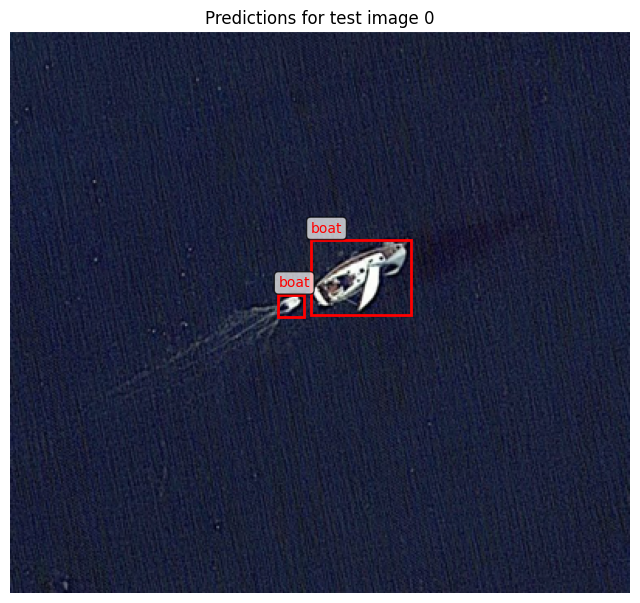

<Figure size 600x600 with 0 Axes>

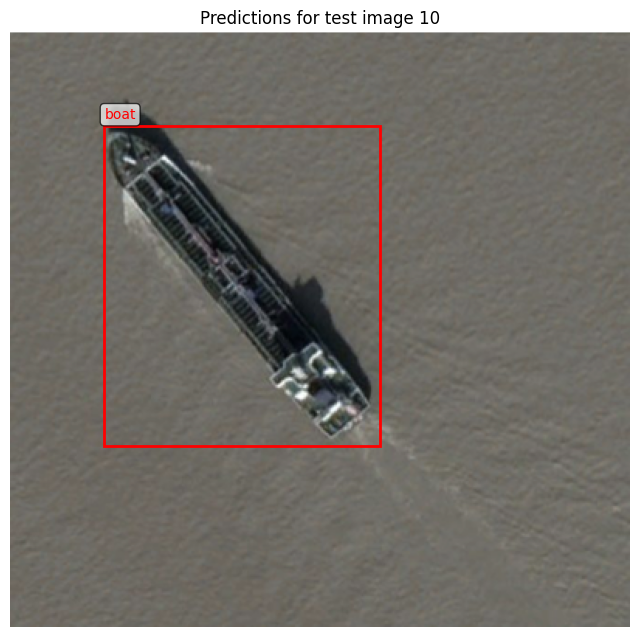

<Figure size 600x600 with 0 Axes>

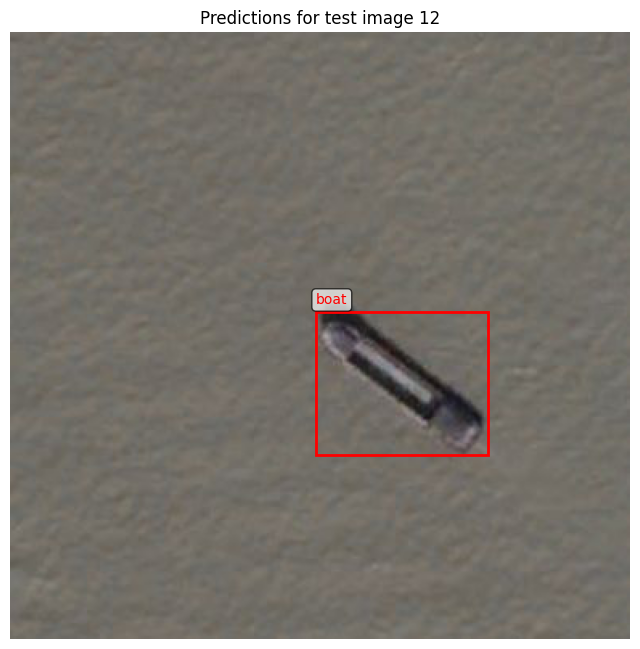

<Figure size 600x600 with 0 Axes>

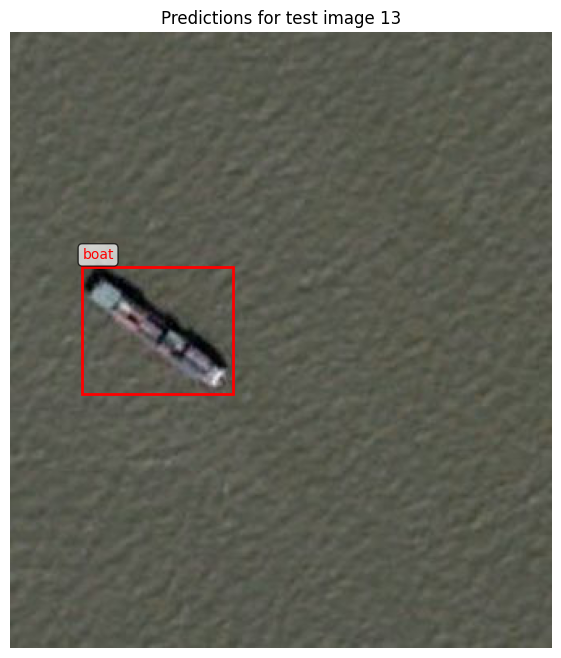

<Figure size 600x600 with 0 Axes>

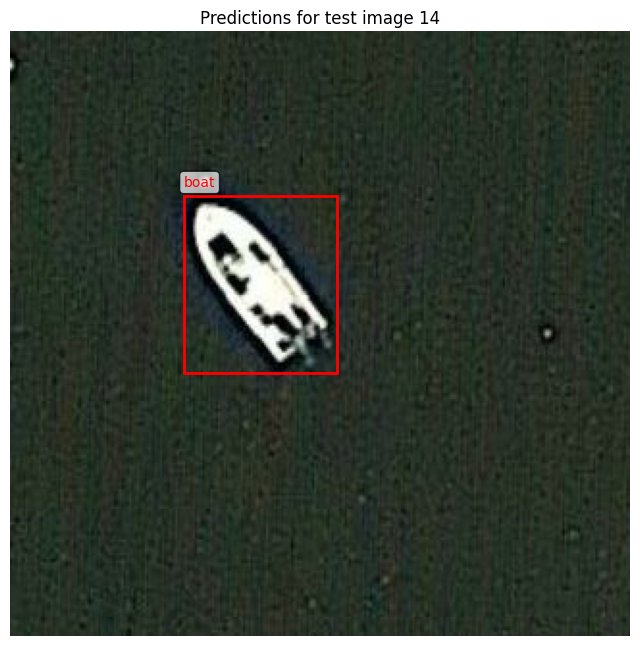

<Figure size 600x600 with 0 Axes>

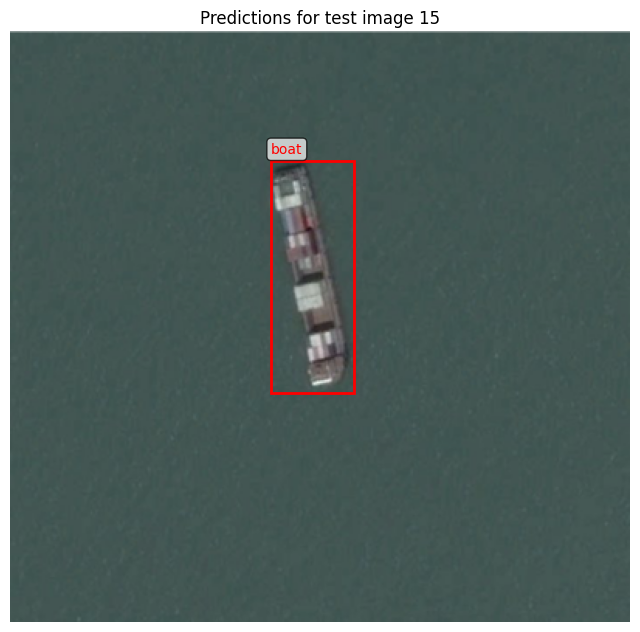

<Figure size 600x600 with 0 Axes>

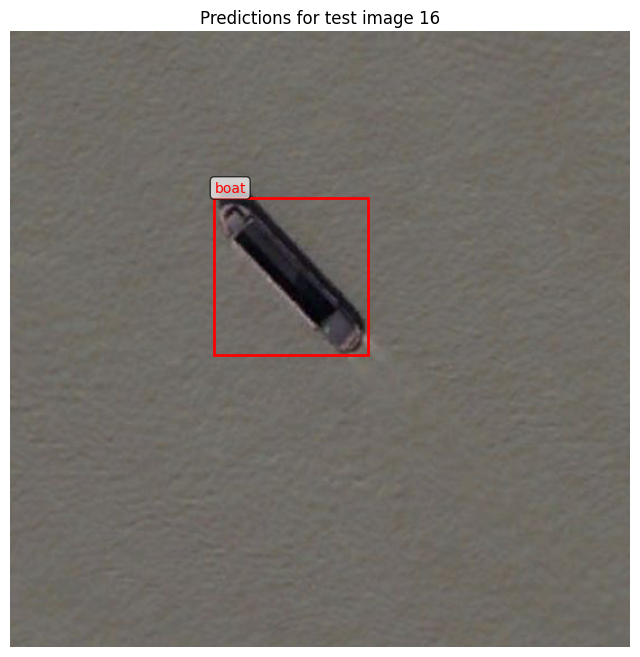

<Figure size 600x600 with 0 Axes>

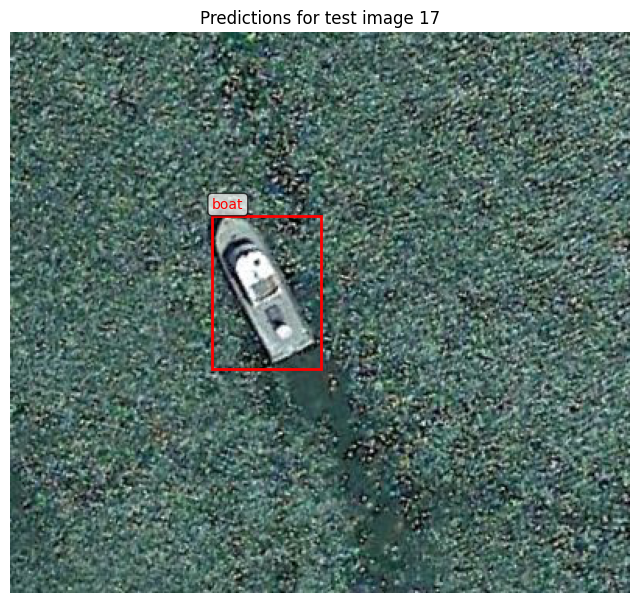

<Figure size 600x600 with 0 Axes>

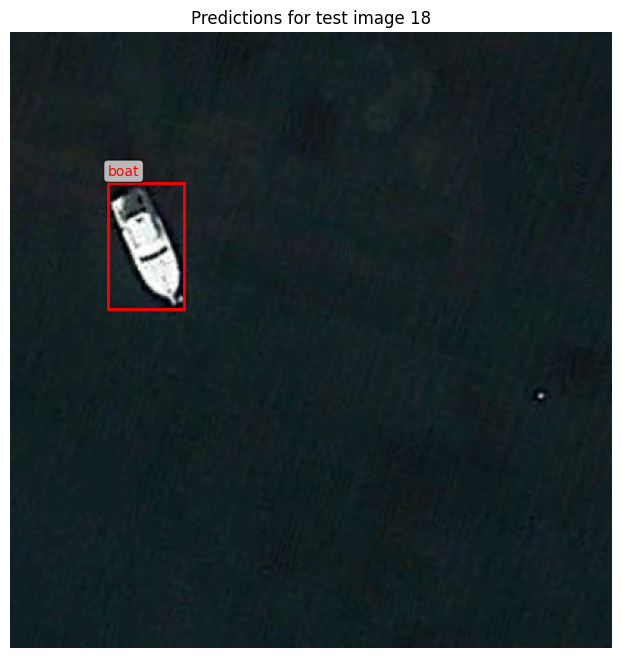

<Figure size 600x600 with 0 Axes>

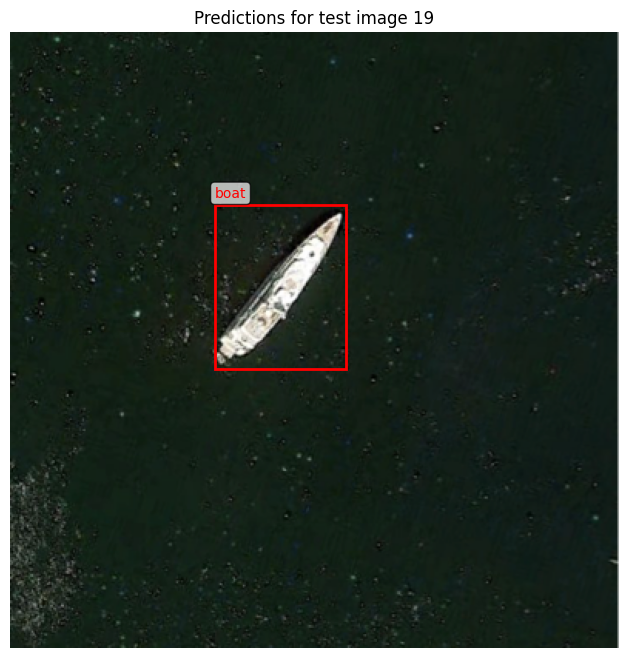

<Figure size 600x600 with 0 Axes>

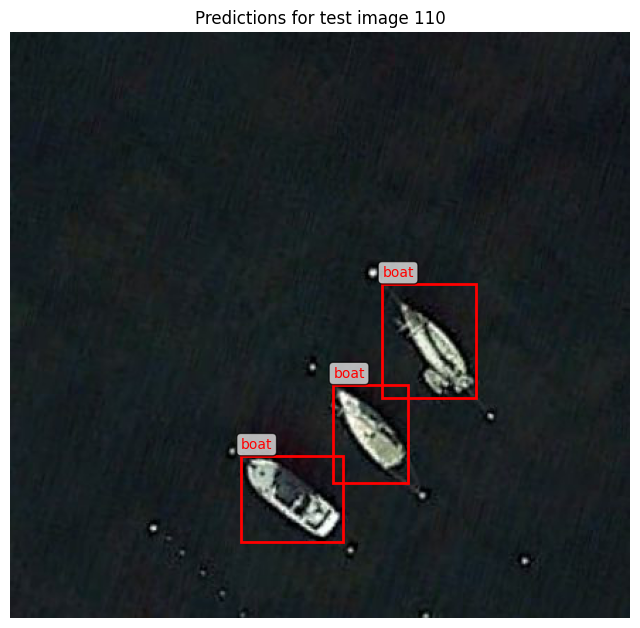

In [39]:
for idx in [0,10,12,13,14,15,16,17,18,19,110]:
    visualize_test_prediction(model, X_test, idx)